In [1]:
import findspark
findspark.init()

In [2]:
# Set up SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("spark-nlp") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.4.5") \
    .getOrCreate()

In [3]:
# Check the SparkSession
spark

In [25]:
# Get data from S3
sc = spark.sparkContext
data = sc.wholeTextFiles("s3://zihe-public/articles/*")

In [26]:
# Functions to extract id, title and text
import re
def get_id(x):
    pattern = "\<doc\sid\=\"(\d+)\"(.*)title\=\"(.*)\"\>"
    pattern_re = re.compile(pattern)
    matches = pattern_re.search(x)
    if not matches:
        return ""
    return matches[1]

def get_title(x):
    pattern = "\<doc\sid\=\"(\d+)\"(.*)title\=\"(.*)\"\>"
    pattern_re = re.compile(pattern)
    matches = pattern_re.search(x)
    if not matches:
        return ""
    return matches[3]

def get_content(x):
    pattern = "\<doc\sid\=\"(\d+)\"(.*)title\=\"(.*)\"\>\\n(.*?)\\n{2}"
    pattern_re = re.compile(pattern)
    matches = pattern_re.search(x)
    if not matches:
        return ""
    idx = matches.end(0)
    return x[idx:]

In [32]:
# Map each page to id, title and content 
pages = data.flatMap(lambda x: (x[1].split('</doc>'))).map(lambda x : (get_id(x), get_title(x), get_content(x)))

In [33]:
# Check type of data
type(pages)

pyspark.rdd.PipelinedRDD

In [34]:
# Check total pages 
pages.count()

6075800

## Explore Article Titles

In [48]:
pages.take(2)[0][1]

'Anarchism'

In [47]:
titles = pages.map(lambda s: s[1])
titles.take(2)

['Anarchism', 'Autism']

In [125]:
# Get lengths of titles
titles_words = titles.map(lambda s: (len(s.split(" ")), 1))
lens = titles_words.reduceByKey(lambda x,y: x+y)
lens.take(2)

[(1, 799806), (2, 2580558)]

In [145]:
# Convert result to dataframe
titles_df = lens.toDF(["title_length", "count"])
titles_df = titles_df.toPandas()
titles_df.head(10)

,title_length,count
0,1,799806
1,2,2580558
2,3,1254760
3,4,639450
4,5,367086
5,6,200223
6,7,105165
7,8,49728
8,9,32808
9,10,22452


In [158]:
# Get longest title
max(titles_df['title_length'])

43

Text(0.5, 1.0, 'Title Length Distribution')

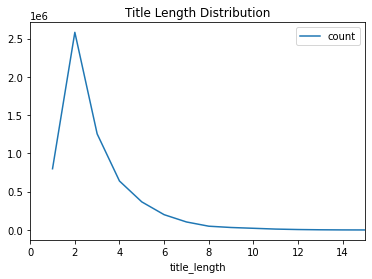

In [157]:
%matplotlib inline
import matplotlib.pyplot as plt
titles_df.plot("title_length", "count", xlim = (0, 15))
plt.title("Title Length Distribution")

## Topic Modling 

In [51]:
import nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hadoop/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [69]:
import nltk
# get the list of stopwords from nltk
from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')
eng_stopwords.append('xxxx')
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer, 
                                LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline

documentAssembler = DocumentAssembler() \
    .setInputCol('title') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# note normalizer defaults to changing all words to lowercase.
# Use .setLowercase(False) to maintain input case.
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized') \
    .setLowercase(True)

# note that lemmatizer needs a dictionary
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(['lemma']) \
    .setOutputCol('clean_lemma') \
    .setCaseSensitive(False) \
    .setStopWords(eng_stopwords)

# finisher converts tokens to human-readable output
finisher = Finisher() \
    .setInputCols(['clean_lemma']) \
    .setCleanAnnotations(False)

pipeline = Pipeline() \
    .setStages([
        documentAssembler,
        tokenizer,
        normalizer,
        lemmatizer,
        stopwords_cleaner,
        finisher
    ])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [77]:
pages = pages.toDF(["id","title","text"])
pages.show(2)

In [ ]:
article = pages[pages['title'] == "Autism"]
article.show()

In [ ]:
# transform titles with the pipeline
cleaned = pipeline.fit(pages).transform(pages)

In [78]:
cleaned = cleaned.selectExpr("id", "finished_clean_lemma")

In [89]:
type(cleaned)

pyspark.sql.dataframe.DataFrame

In [66]:
cleaned.take(10)

[Row(id='12', features=['anarchism']),
 Row(id='25', features=['autism']),
 Row(id='39', features=['albedo']),
 Row(id='290', features=[]),
 Row(id='303', features=['alabama']),
 Row(id='305', features=['achilles']),
 Row(id='307', features=['abraham', 'lincoln']),
 Row(id='308', features=['aristotle']),
 Row(id='309', features=['american', 'paris']),
 Row(id='316', features=['academy', 'award', 'good', 'production', 'design'])]

In [79]:
from pyspark.ml.feature import CountVectorizer
# create a vector of words that at least appeared in two different tweets, and set maximum vocab size to 20000.
vectorizer = CountVectorizer().setInputCol("finished_clean_lemma").setOutputCol("features").setVocabSize(20000).setMinDF(2).fit(
    cleaned)
wordVectors = vectorizer.transform(cleaned).select("id", "features")

In [90]:
wordVectors.take(10)

[Row(id='12', features=SparseVector(20000, {12748: 1.0})),
 Row(id='25', features=SparseVector(20000, {13125: 1.0})),
 Row(id='39', features=SparseVector(20000, {})),
 Row(id='290', features=SparseVector(20000, {})),
 Row(id='303', features=SparseVector(20000, {459: 1.0})),
 Row(id='305', features=SparseVector(20000, {13406: 1.0})),
 Row(id='307', features=SparseVector(20000, {1032: 1.0, 1163: 1.0})),
 Row(id='308', features=SparseVector(20000, {})),
 Row(id='309', features=SparseVector(20000, {38: 1.0, 711: 1.0})),
 Row(id='316', features=SparseVector(20000, {58: 1.0, 114: 1.0, 175: 1.0, 967: 1.0, 997: 1.0}))]

In [83]:
# LDA
from pyspark.ml.clustering import LDA
# create Latent Dirichlet Allocation model and run it on our data with 25 iteration and 5 topics
lda = LDA(k=10, maxIter=25)
# fit the model on data
ldaModel = lda.fit(wordVectors)
# create topics based on LDA
lda_topics = ldaModel.describeTopics()
# show LDA topics

In [91]:
lda_topics.show(11, False)

+-----+----------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                   |termWeights                                                                                                                                                                                                                 |
+-----+----------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[0, 33, 6, 59, 70, 117, 115, 104, 119, 135]   |[0.02243211522673124, 0.020238984635445562, 0.015749959537255054, 0.01454214853957949, 0.010277370243841063, 0.0089475

In [92]:
lda_wordIndices = [row['termIndices'] for row in lda_topics.collect()]

In [98]:
lda_topics_bow = {}
lda_bow_list = []
for curr_idx, lda_topic in enumerate(lda_wordIndices):
    lda_bow_list.clear()
    for idx in range(10):
        lda_bow_list.append(vectorizer.vocabulary[lda_topic[idx]])
    lda_topics_bow[curr_idx] = lda_bow_list[:]
    print("Topic " + str(curr_idx))
    print(lda_bow_list[:])
    print("\n")

Topic 0
['list', 'park', 'county', 'township', 'henry', 'art', 'uss', 'museum', 'bridge', 'pennsylvania']


Topic 1
['railway', 'river', 'station', 'new', 'south', 'james', 'footballer', 'lake', 'bear', 'peter']


Topic 2
['john', 'district', 'island', 'university', 'olympic', 'game', 'group', 'c', 'b', 'summer']


Topic 3
['band', 'basketball', 'love', 'city', 'jack', 'album', 'l', 'line', 'k', 'mens']


Topic 4
['film', 'song', 'j', 'airport', 'list', 'language', 'joseph', 'award', 'surname', 'party']


Topic 5
['de', 'thomas', 'la', 'game', 'college', 'american', 'smith', 'amp', 'andrew', 'tour']


Topic 6
['william', 'george', 'david', 'charles', 'company', 'r', 'mount', 'good', 'act', 'el']


Topic 7
['state', 'disambiguation', 'championship', 'season', 'football', 'world', 'team', 'woman', 'county', 'list']


Topic 8
['school', 'station', 'album', 'st', 'house', 'list', 'high', 'church', 'series', 'tv']


Topic 9
['list', 'north', 'paul', 'album', 'man', 'novel', 'live', 'record'